Here I'm attempting to do a "Plume/Goldsmith analysis" of HCN isotopologues towards the intermediate-mass protostar OMC-2 FIR4. I am focusing on H<sup>13</sup>CN, whose low-J lines (1-0 and 4-3) were observed in [Shimajiri+2015](http://adsabs.harvard.edu/abs/2015ApJS..221...31S), and whose high-J lines (6-5 and 7-6) were observed in [Kama+2013](http://adsabs.harvard.edu/abs/2013A%26A...556A..57K).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import astropy.units as u
import astropy.constants as c

# In Shimajiri, the lines are listed with T_peak and V_fwhm. 
# To get something like an "integrated flux" we do
# flux = 1.0645 * T_peak * V_fwhm.

class Shimajiri_line_flux(object):
    def __init__(self, T_peak, V_fwhm, line_name, frequency, beamsize):
        self.T_peak = T_peak
        self.V_fwhm = V_fwhm
        self.name = line_name
        self.freq = frequency
        self.beam = beamsize
        
        self.flux = self.flux_from_peak_intensity_and_linewidth()
    
    def flux_from_peak_intensity_and_linewidth(self):
        
        flux = 1.0645 * self.T_peak * self.V_fwhm
        
        return flux
    
# Beamsize? From Table 2 of Shimajiri+15
beam_100Ghz = 15.1 * u.arcsec
beam_345GHz = 19.7 * u.arcsec
    
# I'm just gonna sum the T_peaks from each of the 3 hyperfine components, since they
# are all optically thin & have same V_fwhm.
h13cn_10_narrow = Shimajiri_line_flux(
    (0.358 + 0.613 + 0.100)*u.K, 1.83 * u.km/u.s, 
    "h13cn 1-0 narrow", 86.340*u.GHz, beam_100Ghz*(100/86.3) )

h13cn_10_wide = Shimajiri_line_flux(
    (0.041 + 0.07 + 0.011)*u.K, 8.7 * u.km/u.s, 
    "h13cn 1-0 wide", 86.340*u.GHz, beam_100Ghz*(100/86.3) )

h13cn_43_narrow = Shimajiri_line_flux(
    0.259*u.K, 1.68*u.km/u.s, 
    "h13cn 4-3 narrow", 345.339752*u.GHz, beam_345GHz )

h13cn_43_wide = Shimajiri_line_flux(
    0.305*u.K, 8.02*u.km/u.s, 
    "h13cn 4-3 wide", 345.339752*u.GHz, beam_345GHz )


In [3]:
print h13cn_10_narrow.flux
print h13cn_10_wide.flux
print h13cn_43_narrow.flux
print h13cn_43_wide.flux

2.086345485 K km / s
1.1298603 K km / s
0.46318524 K km / s
2.60387345 K km / s


In [4]:
class Kama_line_flux(object):
    def __init__(self, flux, V_fwhm, line_name, frequency, beamsize):
        self.flux = flux
        self.V_fwhm = V_fwhm
        self.name = line_name
        self.freq = frequency
        self.beam = beamsize
        
h13cn_65 = Kama_line_flux(
    0.96*u.K*u.km/u.s, 8.87*u.km/u.s, "h13cn 6-5", 517.970*u.GHz, 41*u.arcsec)

h13cn_76 = Kama_line_flux(
    0.62*u.K*u.km/u.s, 11.10*u.km/u.s, "h13cn 6-5", 517.970*u.GHz, 41*u.arcsec)

In [5]:
print h13cn_65.flux
print h13cn_76.flux

0.96 K km / s
0.62 K km / s


Here's how to get the $N_u$ from an integrated intensity, according to Goldsmith, Bergin, Lis 1997:

$$ N_u (\textrm{cm}^{-2}) = \frac{8\pi \times 10^5 k \nu^2}{A_{ul} hc^3} \int T_\textrm{mb} d\nu$$

The above equation assumes that you are inputting the variables in the following units:
* $k$: Boltzmann constant (ergs/K)
* $\nu$: transition frequency (Hz)
* $A_{ul}$: spontaneous decay rate (s$^{-1}$)
* $h$: Planck's constant (ergs s)
* $c$: speed of light (cm s$^{-1}$)
* $\int T_\textrm{mb} d\nu$: integrated brightness temperature (K km s$^{-1}$)

In the below calculations, I have astropy to do the unit handling properly, which makes the factor $10^5$ in the above equation redundant. I therefore use

$$ N_u (\textrm{cm}^{-2}) = \frac{8\pi k \nu^2}{A_{ul} hc^3} \int T_\textrm{mb} d\nu$$


In [10]:
""" http://home.strw.leidenuniv.nl/~moldata/datafiles/h13cn@xpol.dat
!TRANS + UP + LOW + EINSTEINA(s^-1) + FREQ(GHz) + E_u(K)
    1     2     1   2.2256e-05      86.3398600      4.14
    2     3     2   2.1360e-04     172.6778370     12.43
    3     4     3   7.7240e-04     259.0118140     24.86
    4     5     4   1.8984e-03     345.3397750     41.43
    5     6     5   3.7923e-03     431.6597890     62.15
    6     7     6   6.6521e-03     517.9698290     87.01
    7     8     7   1.0680e-02     604.2679030    116.01
    8     9     8   1.6074e-02     690.5520680    149.15
    9    10     9   2.3033e-02     776.8203590    186.43"""

A_10 = 2.2256e-05 / u.s
A_43 = 1.8984e-03 / u.s
A_65 = 6.6521e-03 / u.s
A_76 = 1.0680e-02 / u.s

def N_upper_from_line(line_object, A_ul):
    
    N_u = (
     (8*np.pi * c.k_B * line_object.freq**2) / 
        (A_ul * c.h * c.c**3) * 
        line_object.flux
        )
    
    return N_u.to(u.cm**-2)

print N_upper_from_line(h13cn_10_narrow, A_10)
print N_upper_from_line(h13cn_10_wide, A_10)
print N_upper_from_line(h13cn_43_narrow, A_43)
print N_upper_from_line(h13cn_43_wide, A_43)

N_7 = N_upper_from_line(h13cn_76, A_76)
N_6 = N_upper_from_line(h13cn_65, A_65)
N_4 = N_upper_from_line(h13cn_43_wide, A_43)
N_1 = N_upper_from_line(h13cn_10_wide, A_10)

N_4_nw = N_upper_from_line(h13cn_43_narrow, A_43) + N_4
N_1_nw = N_upper_from_line(h13cn_10_narrow, A_10) + N_1

source_size = 15*u.arcsec

N_7_beamcorr = N_7 * (h13cn_76.beam/source_size)**2
N_6_beamcorr = N_6 * (h13cn_65.beam/source_size)**2
N_4_beamcorr = N_4 * (h13cn_43_wide.beam/source_size)**2
N_1_beamcorr = N_1 * (h13cn_10_wide.beam/source_size)**2

N_4_nw_beamcorr = N_4_nw * (h13cn_43_wide.beam/source_size)**2
N_1_nw_beamcorr = N_1_nw * (h13cn_10_wide.beam/source_size)**2

print (h13cn_43_wide.beam/source_size)**2
print (h13cn_10_wide.beam/source_size)**2
print (h13cn_76.beam/source_size)**2

1.35821393392e+12 1 / cm2
7.35540692504e+11 1 / cm2
56554232275.0 1 / cm2
3.17929094429e+11 1 / cm2
1.72484444444
1.36066052397
7.47111111111


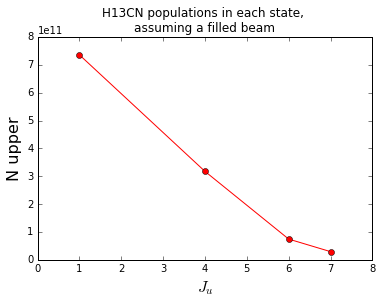

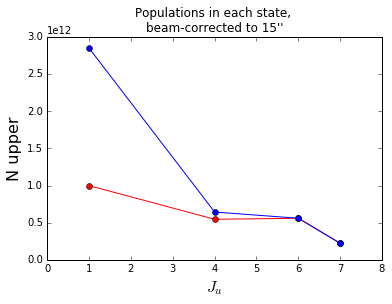

In [15]:
fig = plt.figure()

plt.plot([1,4,6,7], u.Quantity([N_1, N_4, N_6, N_7]), 'ro-')
plt.title("H13CN populations in each state, \nassuming a filled beam")
#plt.plot([1,4,6,7], u.Quantity([N_1_nw, N_4_nw, N_6, N_7]), 'bo-')
plt.xlabel("$J_u$", fontsize=16)
plt.ylabel("N upper", fontsize=16)
plt.xlim(0,8)

fig2 = plt.figure()
plt.plot([1,4,6,7], u.Quantity([N_1_beamcorr, N_4_beamcorr, N_6_beamcorr, N_7_beamcorr]), 'ro-')
plt.plot([1,4,6,7], u.Quantity([N_1_nw_beamcorr, N_4_nw_beamcorr, N_6_beamcorr, N_7_beamcorr]), 'bo-')
plt.title("Populations in each state, \nbeam-corrected to 15''")
plt.xlabel("$J_u$", fontsize=16)
plt.ylabel("N upper", fontsize=16)
plt.xlim(0,8)

plt.show()



In [9]:
print sum([N_1, N_4, N_6, N_7])
print sum([N_1_beamcorr, N_4_beamcorr, N_6_beamcorr, N_7_beamcorr])
print sum([N_1_nw, N_4_nw, N_6_beamcorr, N_7_beamcorr])
print sum([N_1_nw_beamcorr, N_4_nw_beamcorr, N_6_beamcorr, N_7_beamcorr])

1.15899482678e+12 1 / cm2
2.33758871405e+12 1 / cm2
3.25662725086e+12 1 / cm2
4.28320405039e+12 1 / cm2


In [47]:
print N_7_beamcorr / N_7

7.47111111111
